In [1]:
%pip install tf-keras-vis tensorflow


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model("my_keras_model.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,834,885 (254.95 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 44,556,292 (169.97 MB)

In [19]:
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np

# Load the image from the folder
img_path = 'r.jpeg'  # Replace with the path to your image
img = keras_image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
img_array = keras_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input shape

# Normalize the image array if required by your model
img_array /= 255.0

# Predict using the model
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0]


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image

def integrated_gradients(model, baseline, input_image, target_class_idx, m_steps=50, batch_size=32):
    # Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    
    # Compute interpolated inputs between baseline and input
    interpolated_inputs = [baseline + alpha * (input_image - baseline) for alpha in alphas]
    
    # Convert interpolated inputs back to images
    interpolated_images = [keras_image.array_to_img(interpolated_input) for interpolated_input in interpolated_inputs]
    
    interpolated_inputs = tf.stack(interpolated_inputs)  # Stack to create a tensor
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        outputs = model(interpolated_inputs)[:, target_class_idx]
    
    grads = tape.gradient(outputs, interpolated_inputs)
    
    # Average gradients by trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)
    
    # Compute Integrated Gradients
    integrated_grads = (input_image - baseline) * avg_grads
    return integrated_grads, interpolated_images

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_integrated_gradients(image, integrated_grads, title):
    # Ensure integrated_grads is a NumPy array
    integrated_grads = np.array(integrated_grads)
    
    # Check the shape of integrated_grads
    if len(integrated_grads.shape) != 3:
        raise ValueError(f"Expected integrated_grads to have 3 dimensions, but got shape {integrated_grads.shape}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ig_map = np.sum(integrated_grads, axis=-1).squeeze()
    im = ax2.imshow(ig_map, cmap='seismic', vmin=-np.max(np.abs(ig_map)), vmax=np.max(np.abs(ig_map)))
    ax2.set_title('Integrated Gradients')
    ax2.axis('off')
    
    fig.colorbar(im, ax=ax2)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

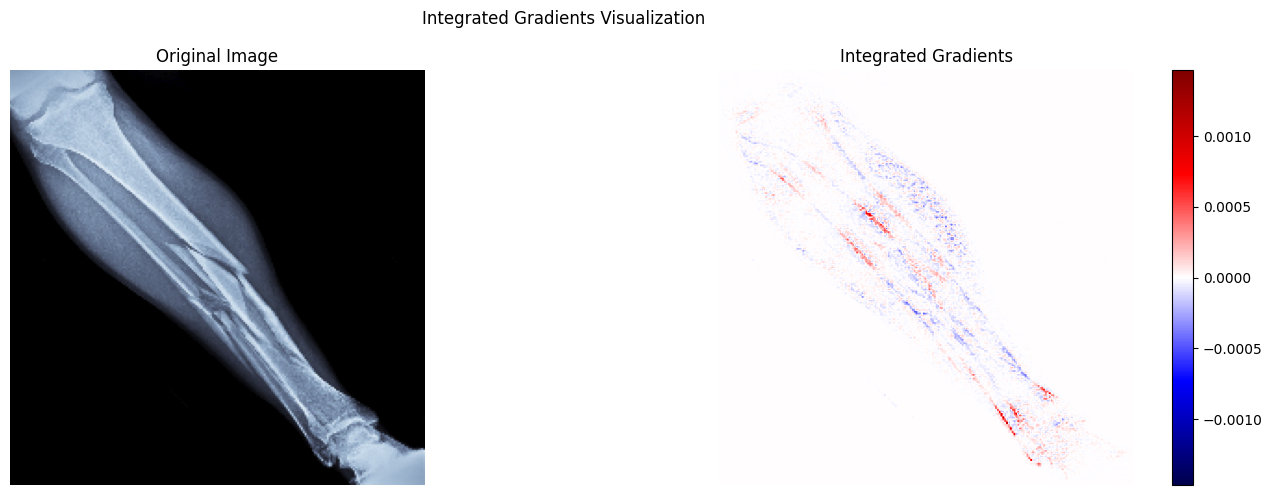

In [31]:
baseline = np.zeros_like(img_array)

# Compute Integrated Gradients
target_class_idx = 0  # Adjust based on your target class
ig, _ = integrated_gradients(model, baseline[0], img_array[0], target_class_idx)

# Visualize the results
visualize_integrated_gradients(img_array[0], ig, "Integrated Gradients Visualization")
